![image.png](attachment:image.png)

## PRACTICA OBLIGATORIA: **Transfer Learning y Fine Tuning**

* La práctica obligatoria de esta unidad consiste en un repetir el ejercicio de construcción de un modelo de clasificación de paisajes pero usando un modelo preentrenado. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo.
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.io import imread
import cv2
from sklearn.utils import shuffle
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from tensorflow.keras import Model
import pandas as pd
from google.colab import files

In [ ]:
uploaded_0 = files.upload()

In [4]:
uploaded_1 = files.upload()

Saving seg_test.zip to seg_test.zip


In [5]:
import zipfile
import io
data_train = zipfile.ZipFile(io.BytesIO(uploaded_0['seg_train.zip']), 'r')
data_train.extractall()

In [6]:

data_test= zipfile.ZipFile(io.BytesIO(uploaded_1['seg_test.zip']), 'r')
data_test.extractall()

In [24]:
ruta_train ="/content/seg_train/seg_train"
ruta_test ="/content/seg_test/seg_test"

In [25]:
def read_data(directorio, reshape_dim = (32,32)):
    X = []
    y = []
    for folder in os.listdir(directorio):
        print(folder)
        if os.path.isdir('/'.join([directorio, folder])):
            for file in os.listdir('/'.join([directorio, folder])):

                image = imread('/'.join([directorio, folder, file]))
                image = cv2.resize(image, reshape_dim) # Redimensionamos las imágenes a 32x32

                X.append(image)
                y.append(folder)

    return np.array(X),np.array(y)

In [26]:
X_train, y_train = read_data(ruta_train)

buildings
sea
forest
street
glacier
mountain


In [27]:
X_test, y_test = read_data(ruta_test)

buildings
sea
forest
street
glacier
mountain


In [28]:
print('X train shape: ', X_train.shape)
print('Y train shape: ', y_train.shape)

X train shape:  (14034, 32, 32, 3)
Y train shape:  (14034,)


In [29]:
print('X test shape: ', X_test.shape)
print('Y test shape: ', y_test.shape)

X test shape:  (3000, 32, 32, 3)
Y test shape:  (3000,)


In [31]:
def show_images_batch(paisajes, names = [], n_cols = 5, size_scale = 2):
    n_rows = ((len(paisajes) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1*size_scale))
    for index, paisaje in enumerate(paisajes):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(paisaje, cmap = "Greys")
        plt.axis("off")
        if len(names):
            plt.title(names[index])

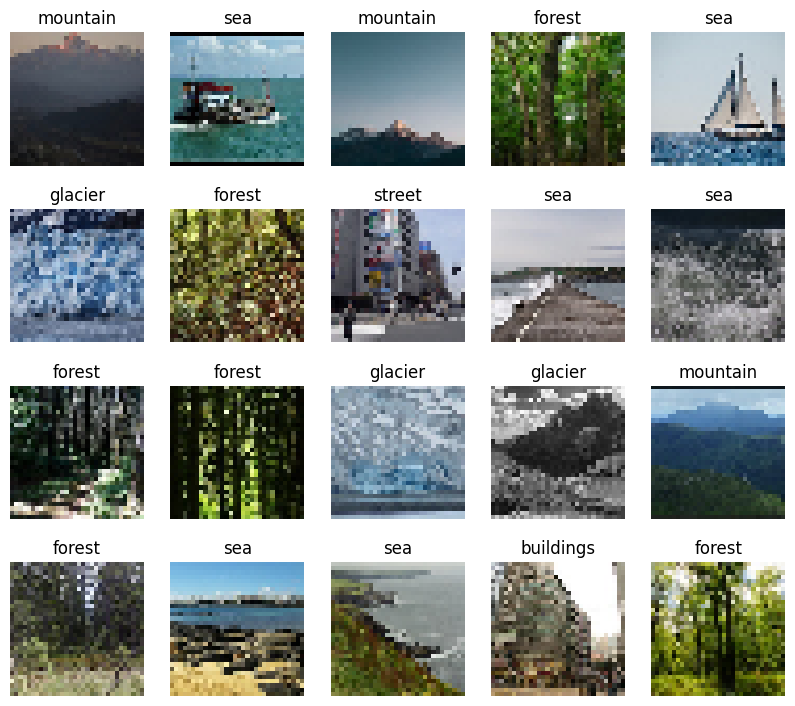

In [32]:
indices = np.random.randint(0,len(X_train),20)
show_images_batch(X_train[indices], names = y_train[indices], n_cols = 5)

In [33]:
targets = pd.Series(y_train)
targets.value_counts(True)

,proportion
mountain,0.178994
glacier,0.171298
street,0.169731
sea,0.162035
forest,0.161821
buildings,0.156121


In [34]:
X_train = X_train/255
X_test = X_test/255

In [36]:
# Barajamos los datos, nos interesa hacerlo con train puesto que son a partir de los cuales aprende el modelo
X_train, y_train = shuffle(X_train, y_train, random_state=42)

In [37]:
y_train

array(['buildings', 'mountain', 'mountain', ..., 'forest', 'buildings',
       'street'], dtype='<U9')

In [38]:
# Maopeamos las categorías a números
categorias = np.unique(y_train)
n_categorias = len(categorias)

mapping = {cat: i for i, cat in enumerate(categorias)}
inverse_mapping = {valor:clave for clave,valor in mapping.items()}

In [39]:
mapping

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [40]:
inverse_mapping

{0: 'buildings',
 1: 'forest',
 2: 'glacier',
 3: 'mountain',
 4: 'sea',
 5: 'street'}

In [41]:
# Mapeamos las etiquetas
y_train_num = np.array([mapping[cat] for cat in y_train])
y_test_num = np.array([mapping[cat] for cat in y_test])

In [ ]:
#2. ZERO SHOT LEARNING: MobileNetV2

In [42]:
#3. TRANSFERT LEARNING

In [43]:
#4. FINE-TUNING

### Objetivo del ejercicio

Comparar una red convolucional hecha ad-hoc frente a los modelos preentrenados y ajustados con fine tuning y transfer learning. Para ello emplea el dataset de paisajes del conjunto de ejercicios de la unidad anterior.


### Se pide

1. Preparar los datos del modelo y las funciones de visualización, copia para ello todo lo que necesites de las soluciones del ejercicio de clasificación de paisajes de la unidad anterior.

2. Escoger entre uno de los modelos VGG-19, InceptionV3 y MobileNetV2 (todos en https://keras.io/api/applications/) (Se aconseja este último si no tenemos un ordenador muy potente). Si no te haces con estos puedes recurrir a la ResNetV50.

4. Hacer un transfer-learning con una cabeza de como mucho 2 capas densas ocultas y una de salida. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

5. Hacer un fine-tuning con la misma cabeza diseñada en el punto anterior. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

6. Comparar los resultados con los obtenidos con la red convolucional del ejercicio mencionado.

EXTRA:
- Repetir el transfer learning empleando aumentado de imágenes.

